<a href="https://colab.research.google.com/github/prathammehta16/Detectron2_On_CustomDataset/blob/main/Detectron2_On_BalloonDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/facebookresearch/detectron2.git

Cloning into 'detectron2'...
remote: Enumerating objects: 14887, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 14887 (delta 32), reused 40 (delta 25), pack-reused 14826
Receiving objects: 100% (14887/14887), 6.07 MiB | 7.83 MiB/s, done.
Resolving deltas: 100% (10779/10779), done.


In [2]:
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=3341f14e27a3f2df7afd8afe1bd39de9c46977653061b1dfcdd47a466335bc20
  Stored in directory: /root/.cache/pip/wheels/04/5f/3e/46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
Successfully built wget


In [3]:
import wget
wget.download('https://github.com/matterport/Mask_RCNN/releases/download/v2.1/balloon_dataset.zip')

'balloon_dataset.zip'

In [4]:
import zipfile
with zipfile.ZipFile("balloon_dataset.zip","r") as zip_ref:
    zip_ref.extractall("balloon_dataset")

In [5]:
!pip uninstall torch
!pip uninstall torchvision
!pip uninstall detectron2

!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/cu111/torch_stable.html
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/index.html

Found existing installation: torch 1.13.1+cu116
Uninstalling torch-1.13.1+cu116:
  Would remove:
    /usr/local/bin/convert-caffe2-to-onnx
    /usr/local/bin/convert-onnx-to-caffe2
    /usr/local/bin/torchrun
    /usr/local/lib/python3.9/dist-packages/functorch/*
    /usr/local/lib/python3.9/dist-packages/torch-1.13.1+cu116.dist-info/*
    /usr/local/lib/python3.9/dist-packages/torch/*
    /usr/local/lib/python3.9/dist-packages/torchgen/*
Proceed (Y/n)? Y
Y
Y
Y
Y
Y
Y
Y
Y
  Successfully uninstalled torch-1.13.1+cu116
Y
Found existing installation: torchvision 0.14.1+cu116
Uninstalling torchvision-0.14.1+cu116:
  Would remove:
    /usr/local/lib/python3.9/dist-packages/torchvision-0.14.1+cu116.dist-info/*
    /usr/local/lib/python3.9/dist-packages/torchvision.libs/libcudart.a44f4c9b.so.11.0
    /usr/local/lib/python3.9/dist-packages/torchvision.libs/libjpeg.ceea7512.so.62
    /usr/local/lib/python3.9/dist-packages/torchvision.libs/libnvjpeg.5afee195.so.11
    /usr/local/lib/python3.9/dis

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import numpy as np
import os, json, cv2, random
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

In [3]:
import matplotlib.pyplot as plt
def cv2_imshow(im):
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure(), plt.imshow(im), plt.axis('off');

In [4]:
def get_balloon_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts





for d in ["train", "val"]:
    DatasetCatalog.register("balloon_" + d, lambda d=d: get_balloon_dicts("balloon_dataset/balloon/" + d))
    MetadataCatalog.get("balloon_" + d).set(thing_classes=["balloon"])

balloon_metadata = MetadataCatalog.get("balloon_train")

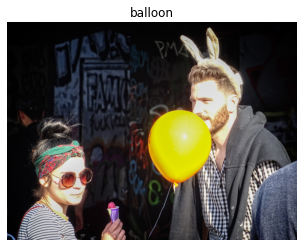

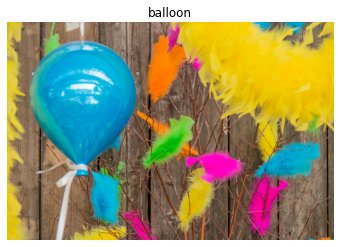

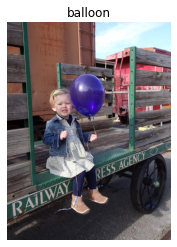

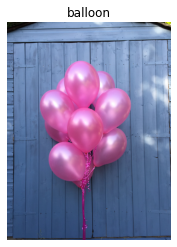

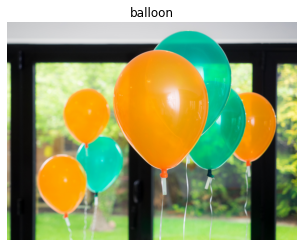

In [9]:
import cv2
import matplotlib.pyplot as plt

dataset_dicts = DatasetCatalog.get("balloon_train")
class_names = MetadataCatalog.get("balloon_train").thing_classes
for d in dataset_dicts[:5]:
    img = cv2.imread(d["file_name"])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(class_names[d["annotations"][0]["category_id"]])
    plt.axis('off')
    plt.show()


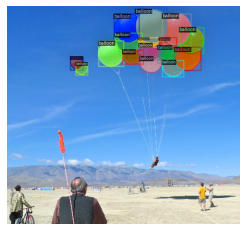

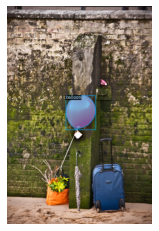

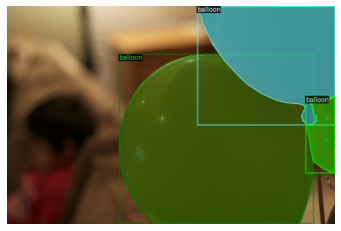

In [5]:
import matplotlib.pyplot as plt
dataset_dicts = get_balloon_dicts("balloon_dataset/balloon/train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=balloon_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

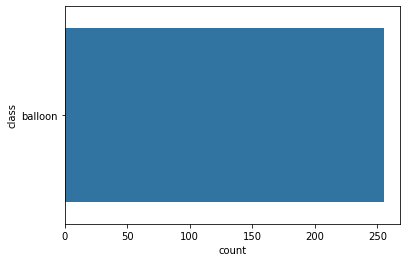

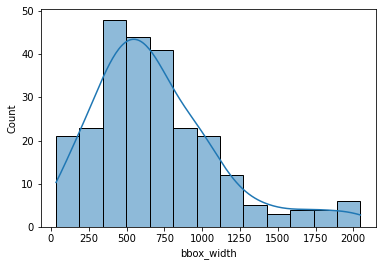

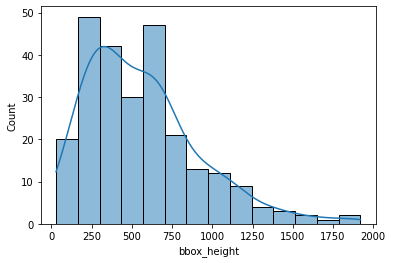

Metadata(name='custom_dataset_train', thing_classes=['balloon'])

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from detectron2.structures import BoxMode

dataset_dicts = DatasetCatalog.get("balloon_train")
class_names = MetadataCatalog.get("balloon_train").thing_classes

df = []
for d in dataset_dicts:
    for ann in d["annotations"]:
        record = {}
        record["filename"] = d["file_name"]
        record["width"] = d["width"]
        record["height"] = d["height"]
        record["class"] = class_names[ann["category_id"]]
        record["xmin"] = ann["bbox"][0]
        record["ymin"] = ann["bbox"][1]
        record["xmax"] = ann["bbox"][0] + ann["bbox"][2]
        record["ymax"] = ann["bbox"][1] + ann["bbox"][3]
        df.append(record)
df = pd.DataFrame(df)

sns.countplot(data=df, y="class")
plt.show()

df["bbox_width"] = df["xmax"] - df["xmin"]
df["bbox_height"] = df["ymax"] - df["ymin"]
sns.histplot(data=df, x="bbox_width", kde=True)
plt.show()
sns.histplot(data=df, x="bbox_height", kde=True)
plt.show()

def get_custom_dataset_dicts():
    dataset_dicts = []
    for idx, row in df.iterrows():
        record = {}
        record["file_name"] = row["filename"]
        record["image_id"] = idx
        record["height"] = row["height"]
        record["width"] = row["width"]
        objs = [{            "bbox": [row["xmin"], row["ymin"], row["xmax"], row["ymax"]],
            "bbox_mode": BoxMode.XYXY_ABS,
            "category_id": class_names.index(row["class"])
        }]
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

DatasetCatalog.register("custom_dataset_train", get_custom_dataset_dicts)
MetadataCatalog.get("custom_dataset_train").set(thing_classes=class_names)


In [11]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
print(cfg)

CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: True
  NUM_WORKERS: 4
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: ()
  TRAIN: ()
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: False
    SIZE: [0.9, 0.9]
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN: (800,)
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: horizontal
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[-90, 0, 90]]
    ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES: [[32, 64, 128, 256, 512]]
  BACKBONE:
    FREEZE_AT: 2
    NAME: build_resnet_backbone
  DEVICE: cuda
  FPN:
    FUSE_TYPE: sum
    IN_FEATURES: []
    NORM: 
    OUT_CHANNELS: 256
  KEYPOINT_ON: False
  LOAD_PROPOSALS: Fals

In [12]:
import torch

torch.cuda.set_device(0)

In [13]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.MODEL.DEVICE = "cuda"
cfg.MODEL.DEVICE_ID = 0
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("balloon_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  
cfg.SOLVER.MAX_ITER = 400    
cfg.SOLVER.STEPS = []        
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[03/10 12:45:35 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:20, 8.75MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[03/10 12:46:06 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.9/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[03/10 12:46:17 d2.utils.events]:  eta: 0:03:02  iter: 19  total_loss: 2.094  loss_cls: 0.7087  loss_box_reg: 0.6166  loss_mask: 0.6937  loss_rpn_cls: 0.05737  loss_rpn_loc: 0.01122  time: 0.5035  data_time: 0.0387  lr: 1.2113e-05  max_mem: 2761M
[03/10 12:46:26 d2.utils.events]:  eta: 0:02:44  iter: 39  total_loss: 2.013  loss_cls: 0.6413  loss_box_reg: 0.7268  loss_mask: 0.6214  loss_rpn_cls: 0.04678  loss_rpn_loc: 0.01213  time: 0.4730  data_time: 0.0113  lr: 2.4601e-05  max_mem: 2761M
[03/10 12:46:37 d2.utils.events]:  eta: 0:02:40  iter: 59  total_loss: 1.709  loss_cls: 0.5245  loss_box_reg: 0.6016  loss_mask: 0.5245  loss_rpn_cls: 0.03039  loss_rpn_loc: 0.006227  time: 0.5024  data_time: 0.0270  lr: 3.7088e-05  max_mem: 2761M
[03/10 12:46:47 d2.utils.events]:  eta: 0:02:33  iter: 79  total_loss: 1.596  loss_cls: 0.4422  loss_box_reg: 0.6639  loss_mask: 0.417  loss_rpn_cls: 0.03821  loss_rpn_loc: 0.007944  time: 0.4986  data_time: 0.0158  lr: 4.9576e-05  max_mem: 2761M
[03/10 12:4

In [14]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  

predictor = DefaultPredictor(cfg)

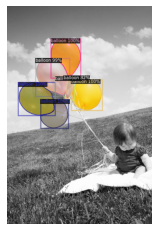

In [16]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_balloon_dicts("balloon_dataset/balloon/val")
for d in random.sample(dataset_dicts, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  
    v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])